# **Seccion 2.2.3 GANs**


**Es necesario volver a importar libreiras, definir algunas funciones clave  y volver a llamar el dataset de fashion MNIST ya que es un cuaderno aparte**

In [1]:
#importamos las librerias a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import tensorflow as tf
from tensorflow import keras

#Llamamos los datos de Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train_full.astype(np.float32)
X_train = X_train.reshape(-1, 28, 28, 1)/255 *2-1
X_test = X_test.astype(np.float32)
X_test = X_test.reshape(-1, 28, 28, 1)/255 *2-1
x_train = tf.concat([X_train, X_test], axis=0)
y_train = tf.concat([y_train_full, y_test], axis=0)

Using TensorFlow backend.


4423680/4422102 [==============================] - 0s 0us/step


# **Definición y entrenamiento**

In [2]:
#Definimos el generador como un modelo secuencial vacio
generator = Sequential()
#Luego añadimos las capas necesarias
generator.add(Dense(7 * 7 * 128, input_shape=[100]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Dropout(0.5))
generator.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding="same",
                                 activation="relu",kernel_initializer="he_normal",kernel_regularizer=keras.regularizers.l2(0.015)))
generator.add(BatchNormalization())
generator.add(Dropout(0.5))
generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding="same",
                                 activation="relu",kernel_initializer="he_normal",kernel_regularizer=keras.regularizers.l2(0.015)))
generator.add(BatchNormalization())
generator.add(Dropout(0.5))
generator.add(Conv2DTranspose(1, kernel_size=3, strides=1, padding="same",
                                 activation="tanh"))
#Y visualizammos el resumen del modelo
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 128)      

In [3]:
#Hacemos lo mismo para la definicion del discriminador
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same",
                        activation=LeakyReLU(0.2),
                        input_shape=[28, 28, 1],kernel_initializer="he_normal",kernel_regularizer=keras.regularizers.l2(0.015)))
discriminator.add(BatchNormalization())
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(64, kernel_size=3, strides=1, padding="same",
                        activation=LeakyReLU(0.2),
                        input_shape=[28, 28, 1],kernel_initializer="he_normal",kernel_regularizer=keras.regularizers.l2(0.015)))
discriminator.add(BatchNormalization())
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same",
                        activation=LeakyReLU(0.2),kernel_initializer="he_normal"))
discriminator.add(BatchNormalization())
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))
#Y lo visualizamos
discriminator.summary()

/opt/conda/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)        

In [4]:
#Definimos un learning rate schedule para darle un poco de control al learning rate y poder jugar con el
learning_rate_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[100],values=[0.01,0.001])

In [5]:
#Ahora si podemos crear la GAN como un modelo secuencial combinando las 2 redes definidas anteriormente
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate_schedule),loss='binary_crossentropy')#Es necesario compilar el discriminador aparte del generador
#Esto se hace para poder manipular cuando se entrena y cuando no
#El discriminador debe aprender solo comparando las imagenes generadas y las reales, no debe entrenarse cuando el generador esta aprendiendo a generar imagenes
discriminator.trainable = False

In [6]:
#Compilar la GAN completa significa compilar para el entrenamiento donde el generador recibe feedback de lo que el discriminador determino como real o falso
GAN.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate_schedule),loss='binary_crossentropy')

In [7]:
#Definimos variables relevantes como el numero de epocas y el batch_size
epochs = 200
batch_size = 64
#esta variable va acorde a como se definio el input del generador, define la forma del ruido que se le entrega como base para la generacion de imagenes
noise_shape=100

Currently on Epoch 1
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  23.947762593626976


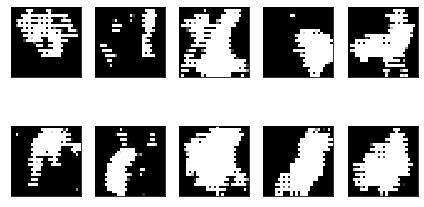

Currently on Epoch 2
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  21.13546636328101
Currently on Epoch 3
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 10

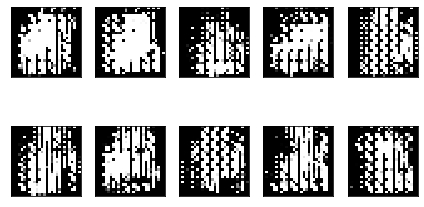

Currently on Epoch 12
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  12.787668811157346
Currently on Epoch 13
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of

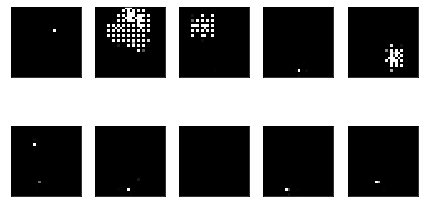

Currently on Epoch 22
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  23.454918349161744
Currently on Epoch 23
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of

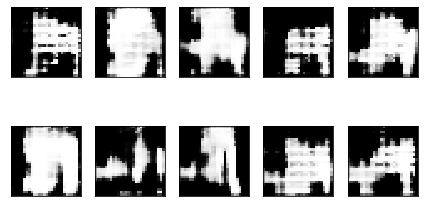

Currently on Epoch 32
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  6.345663584768772
Currently on Epoch 33
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 

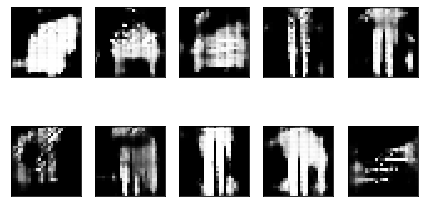

Currently on Epoch 42
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  5.020035192370415
Currently on Epoch 43
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 

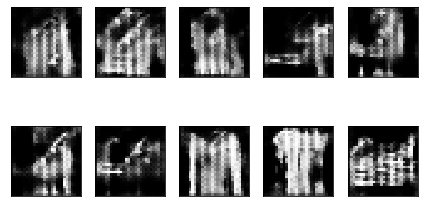

Currently on Epoch 52
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  5.279568813741207
Currently on Epoch 53
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 

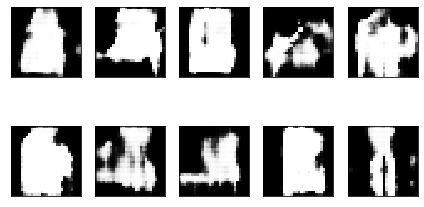

Currently on Epoch 62
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  2.7902779951691628
Currently on Epoch 63
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of

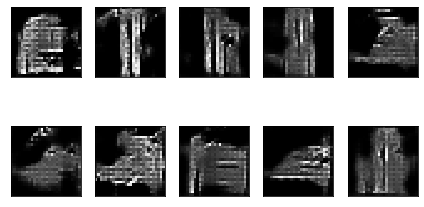

Currently on Epoch 72
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  2.7225111797451973
Currently on Epoch 73
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of

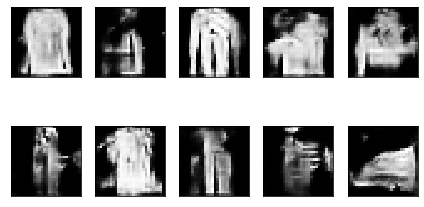

Currently on Epoch 82
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  2.8387202322483063
Currently on Epoch 83
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of

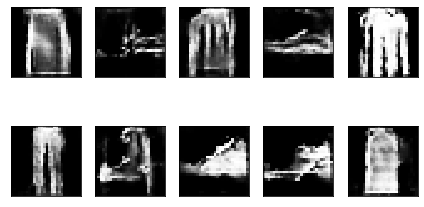

Currently on Epoch 92
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  6.8405402190983295
Currently on Epoch 93
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of

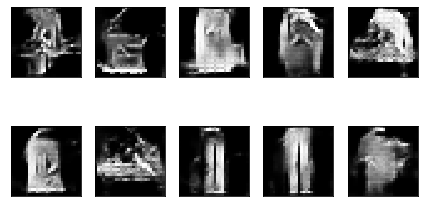

Currently on Epoch 102
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  4.365245021879673
Currently on Epoch 103
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 o

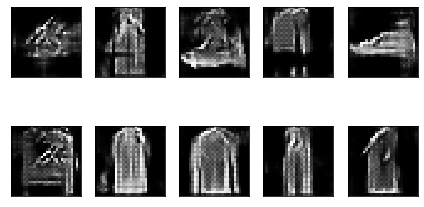

Currently on Epoch 112
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  4.196939263492823
Currently on Epoch 113
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 o

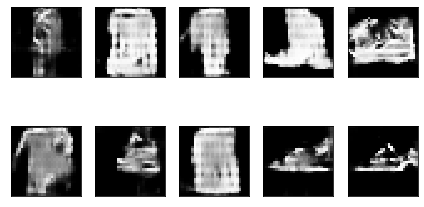

Currently on Epoch 122
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  5.1157460659742355
Currently on Epoch 123
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 

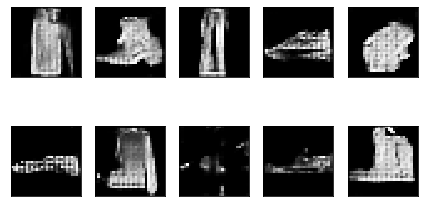

Currently on Epoch 132
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  3.787183351814747
Currently on Epoch 133
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 o

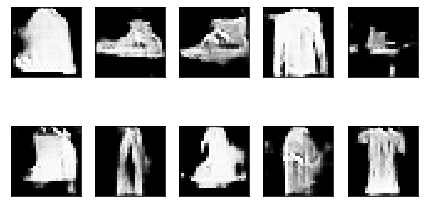

Currently on Epoch 142
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  5.238741330802441
Currently on Epoch 143
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 o

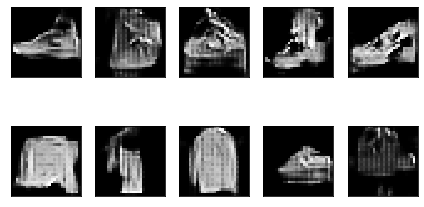

Currently on Epoch 152
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  6.114161241799593
Currently on Epoch 153
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 o

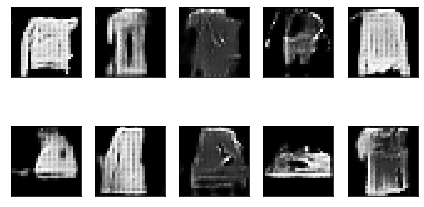

Currently on Epoch 162
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  5.939771834760904
Currently on Epoch 163
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 o

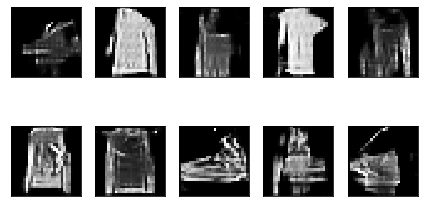

Currently on Epoch 172
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  5.422890044748783
Currently on Epoch 173
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 o

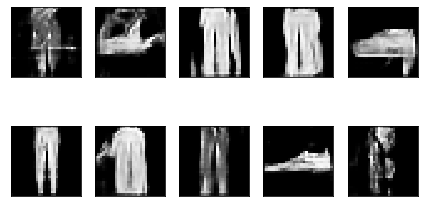

Currently on Epoch 182
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  5.118837051093578
Currently on Epoch 183
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 o

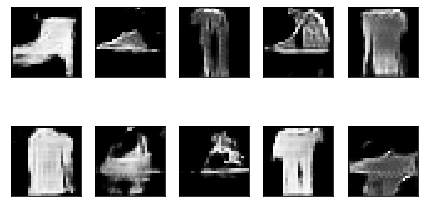

Currently on Epoch 192
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of 1093
	Currently on batch number 200 of 1093
	Currently on batch number 250 of 1093
	Currently on batch number 300 of 1093
	Currently on batch number 350 of 1093
	Currently on batch number 400 of 1093
	Currently on batch number 450 of 1093
	Currently on batch number 500 of 1093
	Currently on batch number 550 of 1093
	Currently on batch number 600 of 1093
	Currently on batch number 650 of 1093
	Currently on batch number 700 of 1093
	Currently on batch number 750 of 1093
	Currently on batch number 800 of 1093
	Currently on batch number 850 of 1093
	Currently on batch number 900 of 1093
	Currently on batch number 950 of 1093
	Currently on batch number 1000 of 1093
	Currently on batch number 1050 of 1093
Loss:  5.99805074557662
Currently on Epoch 193
	Currently on batch number 50 of 1093
	Currently on batch number 100 of 1093
	Currently on batch number 150 of

In [8]:
#Seed para controlar la aleatoreidad del entrenamiento
tf.random.set_seed(42)
np.random.seed(42)

#definimos unas listas vacias para guardar y graficar los valores de las funciones loss
loss=[]
g_loss=[]
d_loss=[]
#Llamamos la gpu a utilizar y definimos el entrenaiento "a pedal" usando un ciclo for
with tf.device('/gpu:0'):
 for epoch in range(epochs): #Recorre el numero de epocas definido
    print(f"Currently on Epoch {epoch+1}")#Muestra la epoca actual que se esta ejecutando
    
    
    for i in range(x_train.shape[0]//batch_size):#Separa los datos en los batches
        
        if (i+1)%50 == 0:
            print(f"\tCurrently on batch number {i+1} of {x_train.shape[0]//batch_size}")#Muestra cuantos batches se han realizado y cuantos faltan en intervalos de 50 por cada epoca
            
        noise=np.random.normal(size=[batch_size,noise_shape])#Crea el ruido para alimentar el generador
       
        gen_image = generator.predict_on_batch(noise)#Genera imagenes falsas usando el generador
        
        train_dataset = x_train[i*batch_size:(i+1)*batch_size]#Toma las imagenes reales del dataset por batches
       
        #Primero entrenamos el discriminador mostrandole imagenes reales
        train_label=np.ones(shape=(batch_size,1))#Define que todas las imagenes que el discriminador va a ver son reales(etiqueta 1)
        discriminator.trainable = True#Define que vamos a entrenar
        d_loss_real=discriminator.train_on_batch(train_dataset,train_label)#Le muestra al discriminador imagenes reales para que trate de predecir que lo son
        
        #Ahora entrenamos sobre imagenes falsas
        train_label=np.zeros(shape=(batch_size,1))#Define que todas las imagenes son falsas (etiqueta 0)
        d_loss_fake=discriminator.train_on_batch(gen_image,train_label)#le muestra al discriminador imagenes creadas por el generador para que trate de predecir que lo son
        
        d_=.5*d_loss_real+0.5*d_loss_fake#juntamos ambos loss en lo que seria el loss total del discriminador
        
        #Ahora entrenamos el generador
        noise=np.random.normal(size=[batch_size,noise_shape])#Creamos ruido nuevo
        train_label=np.ones(shape=(batch_size,1))#Para tratar de engañar al discriminador, decimos que estas imagenes generadas son en realidad imagenes reales del dataset paraver si las clasifica correctamente
        #Esto le da feedback al generador sobre como esta clasificando el discriminador sus imagenes y como mejorarlas 
        discriminator.trainable = False #Apagamos el entrenamiento del discriminador para que solo el generador aprenda
        
        d_g_loss_batch =GAN.train_on_batch(noise, train_label)#Le entrega ruido al generador para que genere imagenes con el feedback del discriminador, tratando de que aprenda a engañar al discriminador
        
        d_loss.append(d_)#Guardamos el loss del discriminador en la lista
        g_loss.append(d_g_loss_batch)#Guardamos el loss del generador en la lista
        batch_loss=.5*d_+.5*d_g_loss_batch#Determinamos el loss del batch con un promedio de ambos loss
        loss.append(batch_loss)#y lo guardamos en la lista del loss total
        
    print("Loss: ",loss[-1])#Visualizamos el loss en cada epoca
    #Y visualizamos imagenes generadas cada 10 epocas
    if epoch % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

        
        
print('Training is complete')

# **Evaluacion del loss**

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


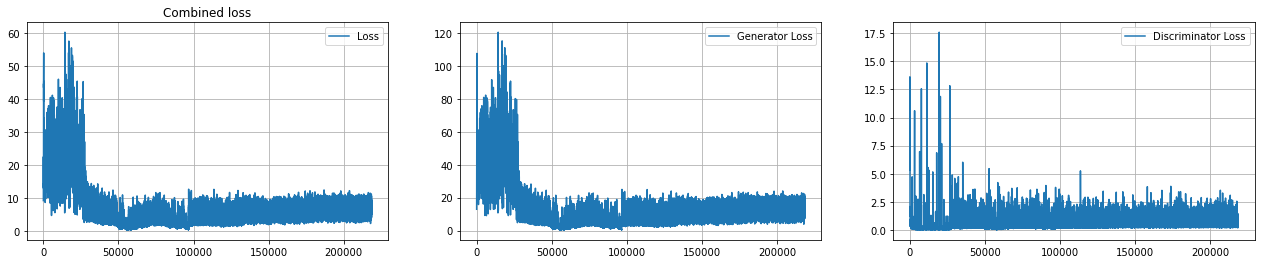

In [9]:
plt.figure(figsize=(22,4))
plt.subplot(1,3,1)
plt.plot(loss,label="Loss")
plt.title("Combined loss")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0,10)
plt.legend()
plt.subplot(1,3,2)
plt.plot(g_loss,label="Generator Loss")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0,10)
plt.legend()
plt.subplot(1,3,3)
plt.plot(d_loss,label="Discriminator Loss")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0,10)
plt.legend()
plt.show()

# **Vusualizacion de las predicciones**

In [10]:
noise=np.random.normal(loc=0, scale=1, size=(100,noise_shape))#Generamos ruido nuevo

gen_image = generator.predict(noise)#Le pedimos al generador que genere imagenes desde ese ruido

**Imagenes reales**

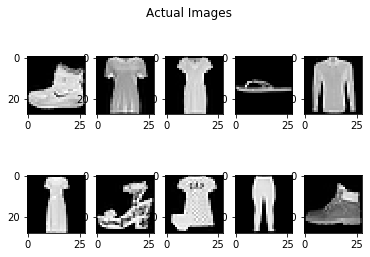

In [11]:
#Vemos in ejemplo de las imagenes reales
fig,axe=plt.subplots(2,5)
fig.suptitle("Actual Images")
plt.grid(False)
idx = 0
for i in range(2):
    for j in range(5):
        axe[i,j].imshow(X_train[idx].reshape(28,28),cmap='gray')
        idx+=10

**Imagenes falsas**

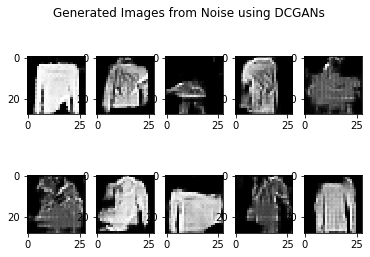

In [12]:
#Y lo comparamos con un ejemplo de las imagenes falsas
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using DCGANs')
idx=0
for i in range(2):
     for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=3

# **Discusion**

* Las GANs son significativamente diferentes a los otros 2 modelos utilizados, y su foco principal no es la reconstruccion de informacion sino la generacion de nueva informacion a partir de los datos de entrenamiento (de alli el nombre de redes GENERATIVAS adversas).
* El entrenamiento de esta red, ademas de ser mucho mas exigente, es sustancialmente diferente a otras, tanto que es necesario usar un bucle o train step diferente al metodo fit regular que se usa con otras redes.
* Durante el entrenamiento es clave separar el generador del discriminador para que no aprendan en los momentos que no deben y controlar correctamente como y desde que aprenden, cabe resaltar que el generador aprende a generar imagenes creibles sin ver nunca una imagen real, todo desde el feedback del discriminador.
* Al existir una competencia constante entre el generador  y el discriminador, la evolucion de las funciones los es extremadamente inestable. Hay que tener mucho cuidado porque si una de las redes gana mucha dominancia la otra no podra recomponerse.
* Por lo anterior se uso una regularizacion fuerte con drop out y L2 en la arquitectura de las redes para tratar de suavizar su evolución, sin embargo habia un limite claro en el que mucha regularizacion llevaba a que las imagenes resultantes fueran cuadriculas o directamente no se generaba nada (posiblemente un problema de gradient vanishing o exploding).
* Podria cuestionar el uso de Adam como optimizador al ser tan inestable, pero la realidad es que es una red pesada cuyo entrenamiento es bastante tardado, y un optimizador tipo SGD podria duplicar las epocas haciendolo inviable. Ademas Adam se puede usar con tasas de aprendizaje mas bajas para tratar de mitigar la fluctuacion. De todas formas como ya se menciono es un entrenamiento muy inestable de por si.
* Basado en los tips de entrenamiento se considero clave usar un learning rate scheduler. De esta forma se le permitio a la red dar unas epocas "mas libres" con tasa de aprendizaje mas elevada y luego tratar de centrarla. Una tasa siempre grande favorece demasiado la fluctuacion en todas las epocas, y una pequeña no ayuda a converger y alargaria el proceso. Usar una mecla de las dos es una buena manera de lograr un equilibrio.
* A pesar de todo no se pudo conseguir un resultado tan satisfactorio, esto por ser una red tan dificil de entrenar y que consume mucho tiempo y recursos. Si se ve una tendencia a mejorar y la grafica de loss muestra una tendencia a la convergencia y una menor fluctuacion en las ultimas epocas del entrenamiento.